# Set-up

In [135]:
# imports
import pandas as pd
import altair as alt


# Data Cleaning

#### First, we'll make a clean dataframe with years as the index from 1950 to 2022

In [136]:
# make the empty dataframe with years from 1950 to 2022 as the index
df = pd.DataFrame(index=range(1950, 2023))
df["Year"] = df.index
# convert the year column to datetime
df["Year"] = pd.to_datetime(df["Year"], format="%Y")


#### Next, we'll need to configure the US census data by taking the overall US population and smoothing for missing years in between census reports

In [137]:
# ingest the census data
census_df = pd.read_excel(
    "00_source_data/population-change-data-table.xlsx", skiprows=3
)
# keep only census columns
census_df = census_df[
    [
        "Area",
        "1910 Census",
        "1920 Census",
        "1930 Census",
        "1940 Census",
        "1950 Census",
        "1960 Census",
        "1970 Census",
        "1980 Census",
        "1990 Census",
        "2000 Census",
        "2010 Census",
        "2020 Census",
    ]
]
# rename the mispelled United States1 to US
census_df.loc[census_df["Area"] == "United States1", "Area"] = "US"
# Pull out only the US row
census_df = census_df[census_df["Area"] == "US"]
# pivot the census data
census_df = census_df.melt(id_vars=["Area"], var_name="Year", value_name="Population")
# drop the Area column
census_df = census_df.drop(columns=["Area"])
# convert the year column to a datetime
census_df["Year"] = pd.to_datetime(census_df["Year"], format="%Y Census")
# convert the population column to an integer
census_df["Population"] = census_df["Population"].astype(int)
# filter for just the years after 1949
census_df = census_df[census_df["Year"] > "1949-12-31"]

census_df


,Year,Population
4,1950-01-01,151325798
5,1960-01-01,179323175
6,1970-01-01,203211926
7,1980-01-01,226545805
8,1990-01-01,248709873
9,2000-01-01,281421906
10,2010-01-01,308745538
11,2020-01-01,331449281


#### Next we will pull in energy production data from government

In [138]:
energy_df = pd.read_csv("00_source_data/MER_T01_02.csv")
# split the YYYYMM column into two columns
energy_df["Year"] = energy_df["YYYYMM"].astype(str).str[:4]
energy_df["Month"] = energy_df["YYYYMM"].astype(str).str[4:]
# convert the year columns to datetime
energy_df["Year"] = pd.to_datetime(energy_df["Year"], format="%Y")
# keep the Value and Year columns
energy_df = energy_df[["Value", "Year"]]
# Rename the value column to energy_prod
energy_df = energy_df.rename(columns={"Value": "Energy_Prod"})
# drop the rows with Not Available
energy_df = energy_df[energy_df["Energy_Prod"] != "Not Available"]
# convert Energy_Prod to a float
energy_df["Energy_Prod"] = energy_df["Energy_Prod"].astype(float)
# groupby year and sum the energy
energy_df = energy_df.groupby("Year").sum()

energy_df.sample(10)


,Energy_Prod
Year,
1965-01-01,151.889730
2019-01-01,592.040642
1992-01-01,406.528384
1987-01-01,395.530432
1980-01-01,397.403944
2015-01-01,513.102810
2000-01-01,411.899216
1973-01-01,379.355858
1978-01-01,372.313276


#### Next is energy consumption

In [139]:
consume_df = pd.read_csv("00_source_data/MER_T01_03.csv")
# split the YYYYMM column into two columns
consume_df["Year"] = consume_df["YYYYMM"].astype(str).str[:4]
consume_df["Month"] = consume_df["YYYYMM"].astype(str).str[4:]
# convert the year columns to datetime
consume_df["Year"] = pd.to_datetime(consume_df["Year"], format="%Y")
# keep the Value and Year columns
consume_df = consume_df[["Value", "Year"]]
# Rename the value column to energy_prod
consume_df = consume_df.rename(columns={"Value": "Energy_Consume"})
# drop the rows with Not Available
consume_df = consume_df[consume_df["Energy_Consume"] != "Not Available"]
# convert Energy_Prod to a float
consume_df["Energy_Consume"] = consume_df["Energy_Consume"].astype(float)
# groupby year and sum the energy
consume_df = consume_df.groupby("Year").sum()

consume_df.sample(10)


,Energy_Consume
Year,
2014-01-01,572.426189
1993-01-01,510.344490
2018-01-01,590.034181
1983-01-01,430.636912
2009-01-01,546.530614
1989-01-01,497.027542
1999-01-01,563.540187
1965-01-01,161.835917
1963-01-01,148.734470


#### Now we have the vehicle efficiency data

In [140]:
veh_df = pd.read_csv("00_source_data/MER_T01_08.csv")
# subset for the rows where unit is Miles per Gallon
veh_df = veh_df[veh_df["Unit"] == "Miles per Gallon"]
# split the YYYYMM column into two columns
veh_df["Year"] = veh_df["YYYYMM"].astype(str).str[:4]
veh_df["Month"] = veh_df["YYYYMM"].astype(str).str[4:]
# convert the year column to datetime
veh_df["Year"] = pd.to_datetime(veh_df["Year"], format="%Y")
# keep Descriptions where the value is All Motor Vehicles Fuel Economy
veh_df = veh_df[veh_df["Description"] == "All Motor Vehicles Fuel Economy"]
# keep the Value and Year columns
veh_df = veh_df[["Value", "Year"]]
# Rename the value column to Veh_MPG
veh_df = veh_df.rename(columns={"Value": "Veh_MPG"})
# convert Veh_MPG to a float
veh_df["Veh_MPG"] = veh_df["Veh_MPG"].astype(float)
# groupby year and take the mean
veh_df = veh_df.groupby("Year").mean()

veh_df.sample(10)


,Veh_MPG
Year,
1996-01-01,16.9
1951-01-01,12.9
1989-01-01,15.9
1982-01-01,14.1
1956-01-01,12.6
1963-01-01,12.5
1970-01-01,12.0
1976-01-01,12.1
1962-01-01,12.4


# Data Merging

#### Now we merge data starting with the census

<AxesSubplot: xlabel='Year'>

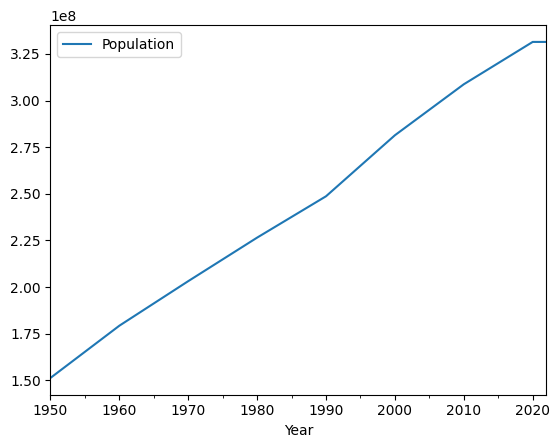

In [141]:
# merge the census data with the empty dataframe
merged_df = pd.merge(df, census_df, on="Year", how="left")
# smooth the population column
merged_df["Population"] = merged_df["Population"].interpolate()
merged_df.plot(x="Year", y="Population")


#### Now we add energy production data

<AxesSubplot: xlabel='Year'>

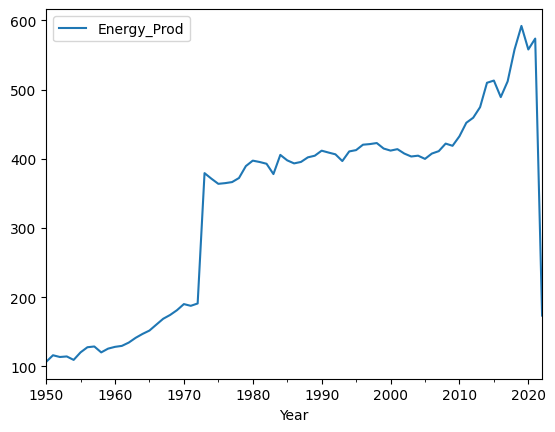

In [142]:
# merge the energy data with the merged dataframe
merged_df2 = pd.merge(merged_df, energy_df, on="Year", how="left").copy()
merged_df2.plot(x="Year", y="Energy_Prod")


#### Now we add energy consumption data

<AxesSubplot: xlabel='Year'>

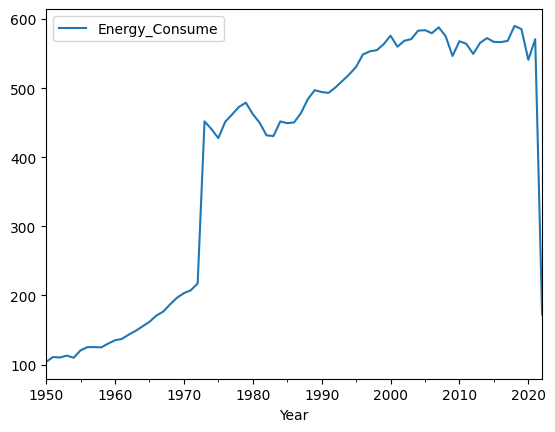

In [143]:
# merge with the consumption data
merged_df3 = pd.merge(merged_df2, consume_df, on="Year", how="left").copy()
merged_df3.plot(x="Year", y="Energy_Consume")


#### The last merge will be the vehicle efficiency data

<AxesSubplot: xlabel='Year'>

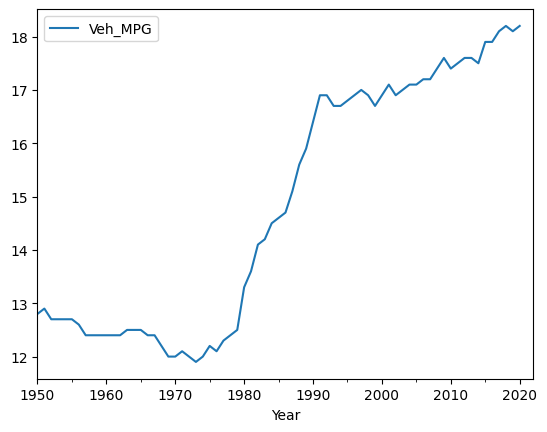

In [144]:
# merge vehicle data
merged_df4 = pd.merge(merged_df3, veh_df, on="Year", how="left").copy()
merged_df4.plot(x="Year", y="Veh_MPG")


# Output File as a CSV

In [146]:
# save merged df4 to a csv in the 20_clean_data_directory
merged_df4.to_csv("20_clean_data/merged_df4.csv", index=False)
